# Set up

In [922]:
import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization

# Sourcing

In [923]:
# df = pd.read_csv("../../data/raw/train.csv")
# #Save to .feather file for later use with lighter memory, and also git does not allow heavy file, so .csv file cannot be uploaded to the repo
# df.to_feather("../../data/raw/train.feather")

In [924]:
df = pd.read_feather("../../data/raw/train.feather")

In [925]:
data = df.copy()

In [926]:
data.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0


In [927]:
data.dtypes

id                                  int64
target                             object
home_team_name                     object
away_team_name                     object
match_date                         object
                                   ...   
away_team_history_league_id_6     float64
away_team_history_league_id_7     float64
away_team_history_league_id_8     float64
away_team_history_league_id_9     float64
away_team_history_league_id_10    float64
Length: 190, dtype: object

# Data pre-processing

In [928]:
data['home_team_name'].nunique()

9813

In [929]:
data['away_team_name'].nunique()

9892

In [930]:
data['target'].unique().tolist()

['away', 'home', 'draw']

In [931]:
data['league_id'].nunique()

862

- These categorical columns have too many distinct values, which may create memory constrain for encoding
- The historical data columns also have these many distinct values

In [932]:
null_columns = data.columns[data.isnull().any()]

In [933]:
null_columns.tolist()

['home_team_name',
 'away_team_name',
 'league_name',
 'is_cup',
 'home_team_coach_id',
 'away_team_coach_id',
 'home_team_history_match_date_1',
 'home_team_history_match_date_2',
 'home_team_history_match_date_3',
 'home_team_history_match_date_4',
 'home_team_history_match_date_5',
 'home_team_history_match_date_6',
 'home_team_history_match_date_7',
 'home_team_history_match_date_8',
 'home_team_history_match_date_9',
 'home_team_history_match_date_10',
 'home_team_history_is_play_home_1',
 'home_team_history_is_play_home_2',
 'home_team_history_is_play_home_3',
 'home_team_history_is_play_home_4',
 'home_team_history_is_play_home_5',
 'home_team_history_is_play_home_6',
 'home_team_history_is_play_home_7',
 'home_team_history_is_play_home_8',
 'home_team_history_is_play_home_9',
 'home_team_history_is_play_home_10',
 'home_team_history_is_cup_1',
 'home_team_history_is_cup_2',
 'home_team_history_is_cup_3',
 'home_team_history_is_cup_4',
 'home_team_history_is_cup_5',
 'home_team_

- It's obvious that the historical columns might contain null values, but there are columns that are not supposed to have nulls

In [934]:
null_col_to_check = ['home_team_name',
 'away_team_name',
 'league_name',
 'is_cup',
 'home_team_coach_id',
 'away_team_coach_id',]

In [935]:
data[data['home_team_name'].isnull()]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
33562,16622092,away,None,None,2020-07-23 15:00:00,None,1101,None,NaN,NaN,...,830.0,1108.0,1108.0,1412.0,830.0,830.0,1108.0,830.0,1108.0,830.0


In [936]:
data[data['away_team_name'].isnull()]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
33562,16622092,away,None,None,2020-07-23 15:00:00,None,1101,None,NaN,NaN,...,830.0,1108.0,1108.0,1412.0,830.0,830.0,1108.0,830.0,1108.0,830.0


In [937]:
data[data['league_name'].isnull()]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
33562,16622092,away,None,None,2020-07-23 15:00:00,None,1101,None,NaN,NaN,...,830.0,1108.0,1108.0,1412.0,830.0,830.0,1108.0,830.0,1108.0,830.0


In [938]:
data[data['is_cup'].isnull()]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
33562,16622092,away,None,None,2020-07-23 15:00:00,None,1101,None,NaN,NaN,...,830.0,1108.0,1108.0,1412.0,830.0,830.0,1108.0,830.0,1108.0,830.0


- It seems like the match with id = 16622092 lacking a lot of data => Remove this match

In [939]:
data = data[data['id']!=16622092]

In [940]:
data.reset_index(drop=True, inplace=True)

In [941]:
data[data['home_team_coach_id'].isnull()]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
1014,11985210,draw,Bassam,AFAD,2019-12-04 15:30:00,Ligue 1,827,False,NaN,NaN,...,827.0,827.0,827.0,827.0,827.0,827.0,NaN,NaN,NaN,NaN
1040,11985211,home,ASEC Mimosas,Tanda,2019-12-04 18:00:00,Ligue 1,827,False,NaN,NaN,...,827.0,827.0,827.0,827.0,827.0,827.0,NaN,NaN,NaN,NaN
1119,11985565,draw,Busan I'Park,Gyeongnam,2019-12-05 10:00:00,K-League Relegation,1662,False,NaN,NaN,...,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0
2123,11986033,home,Kenya,Tanzania,2019-12-08 13:00:00,CECAFA Senior Challenge Cup,1110,True,NaN,NaN,...,1118.0,1118.0,1103.0,1082.0,1103.0,711.0,711.0,1103.0,1103.0,1117.0
2517,11929342,away,Fuente Cantos,Moralo,2019-12-09 11:00:00,Tercera - Group 14,1271,False,NaN,NaN,...,1271.0,1271.0,1271.0,1271.0,1271.0,1271.0,1271.0,1589.0,1589.0,1589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110909,18012778,draw,Delfines Del Este,Don Bosco Jarabacoa,2021-04-30 21:00:00,Liga Mayor,1341,False,NaN,NaN,...,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0
110922,17883598,away,EB / Streymur II,B71,2021-04-30 22:00:00,1. Deild,280,False,NaN,37525676.0,...,280.0,280.0,280.0,280.0,280.0,280.0,280.0,280.0,280.0,280.0
110923,17883597,away,HB II,NSÍ II,2021-04-30 22:00:00,1. Deild,280,False,NaN,NaN,...,280.0,280.0,280.0,280.0,280.0,280.0,280.0,280.0,280.0,280.0
110925,18036579,draw,Hawks,Armed Forces,2021-04-30 22:30:00,GFA League,1644,False,NaN,NaN,...,1644.0,1644.0,1644.0,1107.0,NaN,NaN,NaN,NaN,NaN,NaN


In [942]:
data[data['away_team_coach_id'].isnull()]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
1014,11985210,draw,Bassam,AFAD,2019-12-04 15:30:00,Ligue 1,827,False,NaN,NaN,...,827.0,827.0,827.0,827.0,827.0,827.0,NaN,NaN,NaN,NaN
1040,11985211,home,ASEC Mimosas,Tanda,2019-12-04 18:00:00,Ligue 1,827,False,NaN,NaN,...,827.0,827.0,827.0,827.0,827.0,827.0,NaN,NaN,NaN,NaN
1119,11985565,draw,Busan I'Park,Gyeongnam,2019-12-05 10:00:00,K-League Relegation,1662,False,NaN,NaN,...,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0,1034.0
2123,11986033,home,Kenya,Tanzania,2019-12-08 13:00:00,CECAFA Senior Challenge Cup,1110,True,NaN,NaN,...,1118.0,1118.0,1103.0,1082.0,1103.0,711.0,711.0,1103.0,1103.0,1117.0
2517,11929342,away,Fuente Cantos,Moralo,2019-12-09 11:00:00,Tercera - Group 14,1271,False,NaN,NaN,...,1271.0,1271.0,1271.0,1271.0,1271.0,1271.0,1271.0,1589.0,1589.0,1589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110909,18012778,draw,Delfines Del Este,Don Bosco Jarabacoa,2021-04-30 21:00:00,Liga Mayor,1341,False,NaN,NaN,...,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0,1341.0
110910,18044975,home,Nouadhibou,Sahel,2021-04-30 21:15:00,Super D1,1524,False,37410400.0,NaN,...,1524.0,1524.0,1524.0,1524.0,1524.0,1524.0,1524.0,1524.0,1524.0,1524.0
110923,17883597,away,HB II,NSÍ II,2021-04-30 22:00:00,1. Deild,280,False,NaN,NaN,...,280.0,280.0,280.0,280.0,280.0,280.0,280.0,280.0,280.0,280.0
110925,18036579,draw,Hawks,Armed Forces,2021-04-30 22:30:00,GFA League,1644,False,NaN,NaN,...,1644.0,1644.0,1644.0,1107.0,NaN,NaN,NaN,NaN,NaN,NaN


- Since there are lots of null in the historical data, and the diversity of football teams, coaches and leagues, processing the null values is not the good choice
- Also with lots of dates (1 for current and 10 for historical), extracting features like day of week, week of year, month of year, year, shall be extending the dimension of the data a lot
- Even with this large distinct and non-ordinal values, encoding should not sufficient in this case

### In stead, feature engineering should be apply to extract the insights from the dataset and use them as the features, then the id of leagues, coaches, football teams shall be removed

# Feature engineering

Below are the historical features:
- home_team_history_match_date_{i} - The date of the last i-th match played by Home team.
- home_team_history_is_play_home_{i} - If 1, the Home team played home.
- home_team_history_is_cup_{i} - If 1, the match was a cup competition.
- home_team_history_goal_{i} - The number of goals scored by the Home team on its last i-th match.
- home_team_history_opponent_goal_{i} - The number of goals conceded by the Home team on its last i-th match.
- home_team_history_rating_{i} - The rating of the Home team on its last i-th match (pre match rating).
- home_team_history_opponent_rating_{i} - The rating of the opponent team on Home team last i-th match (pre match rating).
- home_team_history_coach_{i} - The coach id of the Home team on its last i-th match.
- home_team_history_league_id_{i} - The league name id by the Home team on its last i-th match.
- away_team_history_match_date_{i} - The date of the last i-th match played by Away team.
- away_team_history_is_play_home_{i} - If 1, the Away team played home.
- away_team_history_is_cup_{i} - If 1, the match was a cup competition.
- away_team_history_goal_{i} - The number of goals scored by the Away team on its last i-th match.
- away_team_history_opponent_goal_{i} - The number of goals conceded by the Away team on its last i-th match.
- away_team_history_rating_{i} - The rating of the Away team on its last i-th match (pre match rating).
- away_team_history_opponent_rating_{i} - The rating of the opponent team on Away team last i-th match (pre match rating).
- away_team_history_coach_{i} - The coach id of the Away team on its last i-th match.
- away_team_history_league_id_{i} - The league name id played by the Away on its last i-th match.

It's obvious that these informations are too many to analyze and explore, also not all shall be beneficial for the models, therefore, insights should be extracted, below are few ones:
- home_team_history_match_date_{i}:
    + How many days from the last match => This can impact to the rest time of the team and therefore can impact to the game result
    + How many matches the team has played for the last 30 days => Impact to the rest time of the team
- home_team_history_is_play_home_{i}:
    + How many times the team has played home in the last 30 days => Impact to the rest time and spirit of the team
- home_team_history_is_cup_{i}:
    + If the last match was the cup competition => Impact to the team's members playing on this match
    + How many cup competition games the team has played in the last 30 days => Impact to the team's members playing continuously, therefore can impact to the game result
    + How many cup competition matches in the last 10 matches
- home_team_history_goal_{i}:
    + How many goals the home team has scored on last match
    + Average goals the home team has scored on each match
    + Average goals the home team has score in the last 30 days
- home_team_history_opponent_goal_{i}:
    + How many goals the opponent of home team has scored on last match
    + Average goals the opponent of home team has scored on each match
    + Average goals the opponent of home team has scored in the last 30 days
- home_team_history_rating_{i}:
    + Last rating of the home team
    + Average rating of the home team
    + Average rating of the home team in the last 30 days
- home_team_history_opponent_rating_{i}:
    + Last rating of the opponent of the home team
    + Average rating of the opponent of the home team
    + Average rating of the opponent of the home team in the last 30 days
- home_team_history_league_id_{i}:
    + Last match on the same league or not
    + How many different leagues for the last 30 days
    + How many different leagues for the last 10 matches
- away_team_history_match_date_{i}:
    + How many days from the last match of the away team
    + How many matches the away team has played for the last 30 days
- away_team_history_is_play_home_{i}:
    + How many times the away team has played home in the last 30 days
- away_team_history_is_cup_{i}:
    + If the last match was the cup competition
    + How many cup competition games the away team has played in the last 30 days
    + How many cup competition matches in the last 10 matches
- away_team_history_goal_{i}:
    + How many goals the away team has scored on last match
    + Average goals the away team has scored on each match
    + Average goals the away team has score in the last 30 days
- away_team_history_opponent_goal_{i}:
    + How many goals the opponent of away team has scored on last match
    + Average goals the opponent of home team has scored on each match
    + Average goals the opponent of away team has scored in the last 30 days
- away_team_history_rating_{i}:
    + Last rating of the away team
    + Average rating of the away team
    + Average rating of the away team in the last 30 days
- away_team_history_opponent_rating_{i}:
    + Last rating of the opponent of the away team
    + Average rating of the opponent of the away team
    + Average rating of the opponent of the away team in the last 30 days
- away_team_history_league_id_{i}:
    + Last match on the same league or not
    + How many different leagues for the last 30 days
    + How many different leagues for the last 10 matches

Any information related to coach shall be not used as feature, these kinds of information could contribute a lot of the model, but since the data (both historical and current) are too lacking, and also other features (goals, rating, etc) could represent the coach => These features shall be removed (might be re-considered later)

In [943]:
coach_related_columns = data.filter(like='coach').columns.tolist()

In [944]:
data = data.drop(columns=coach_related_columns, axis=1)

In [945]:
data.columns

Index(['id', 'target', 'home_team_name', 'away_team_name', 'match_date',
       'league_name', 'league_id', 'is_cup', 'home_team_history_match_date_1',
       'home_team_history_match_date_2',
       ...
       'away_team_history_league_id_1', 'away_team_history_league_id_2',
       'away_team_history_league_id_3', 'away_team_history_league_id_4',
       'away_team_history_league_id_5', 'away_team_history_league_id_6',
       'away_team_history_league_id_7', 'away_team_history_league_id_8',
       'away_team_history_league_id_9', 'away_team_history_league_id_10'],
      dtype='object', length=168)

In [946]:
data.filter(like='coach').columns

Index([], dtype='object')

## Features for date

In [947]:
date_related_columns = data.filter(like='date').columns.tolist()

In [948]:
date_related_columns

['match_date',
 'home_team_history_match_date_1',
 'home_team_history_match_date_2',
 'home_team_history_match_date_3',
 'home_team_history_match_date_4',
 'home_team_history_match_date_5',
 'home_team_history_match_date_6',
 'home_team_history_match_date_7',
 'home_team_history_match_date_8',
 'home_team_history_match_date_9',
 'home_team_history_match_date_10',
 'away_team_history_match_date_1',
 'away_team_history_match_date_2',
 'away_team_history_match_date_3',
 'away_team_history_match_date_4',
 'away_team_history_match_date_5',
 'away_team_history_match_date_6',
 'away_team_history_match_date_7',
 'away_team_history_match_date_8',
 'away_team_history_match_date_9',
 'away_team_history_match_date_10']

In [949]:
for dt_col in date_related_columns:
    data[dt_col] = data[dt_col].astype('datetime64[ns]')

In [950]:
data['home_team_days_from_last_match'] = data['match_date'] - data['home_team_history_match_date_1']
data['home_team_days_from_last_match'] = data['home_team_days_from_last_match']/pd.Timedelta(days=1)

In [951]:
data['away_team_days_from_last_match'] = data['match_date'] - data['away_team_history_match_date_1']
data['away_team_days_from_last_match'] = data['away_team_days_from_last_match']/pd.Timedelta(days=1)

In [952]:
data['30_day_ago_match_date'] = data['match_date'] - pd.DateOffset(days=30)

In [953]:
home_match_date_cols = data.filter(like='home_team_history_match_date_').columns.tolist()

In [954]:
away_match_date_cols = data.filter(like='away_team_history_match_date_').columns.tolist()

In [955]:
i=1
for col in home_match_date_cols:
    index_col = f"home_team_date_index_{i}"
    mask = (data[col] >= data['30_day_ago_match_date']) & (data[col] <= data['match_date'])
    # The index col is for later use to count the insights with timeframe in 30 days
    data[col] = mask.astype(int)
    data[index_col] = mask.astype(int)
    i+=1

In [956]:
i=1
for col in away_match_date_cols:
    index_col = f"away_team_date_index_{i}"
    mask = (data[col] >= data['30_day_ago_match_date']) & (data[col] <= data['match_date'])
    # The index col is for later use to count the insights with timeframe in 30 days
    data[col] = mask.astype(int)
    data[index_col] = mask.astype(int)
    i+=1

In [957]:
data['home_team_total_matches_last_30_days'] = data[home_match_date_cols].sum(axis=1)

In [958]:
data['away_team_total_matches_last_30_days'] = data[away_match_date_cols].sum(axis=1)

In [959]:
home_team_match_30_day_index = data.filter(like='home_team_date_index_').columns.tolist()

In [960]:
away_team_match_30_day_index = data.filter(like='away_team_date_index_').columns.tolist()

In [961]:
data.drop(columns=home_match_date_cols, inplace=True)
data.drop(columns=away_match_date_cols, inplace=True)

## Features for play home

In [962]:
home_team_play_home = data.filter(like='home_team_history_is_play_home_').columns.tolist()

In [963]:
away_team_play_home = data.filter(like='away_team_history_is_play_home_').columns.tolist()

In [964]:
data[home_team_play_home] = data[home_team_play_home].fillna(0)

In [965]:
data[away_team_play_home] = data[away_team_play_home].fillna(0)

In [966]:
data['home_team_matches_play_home_last_30_days'] = 0
for i in range(0,10):
    data['home_team_matches_play_home_last_30_days'] += data[home_team_play_home[i]] * data[home_team_match_30_day_index[i]]

In [967]:
data['away_team_matches_play_home_last_30_days'] = 0
for i in range(0,10):
    data['away_team_matches_play_home_last_30_days'] += data[away_team_play_home[i]] * data[away_team_match_30_day_index[i]]

In [968]:
data.drop(columns=home_team_play_home, inplace=True)
data.drop(columns=away_team_play_home, inplace=True)

## Features for cup competition

In [969]:
home_team_is_cup = data.filter(like='home_team_history_is_cup').columns.tolist()

In [970]:
away_team_is_cup = data.filter(like='away_team_history_is_cup').columns.tolist()

In [971]:
data['home_team_matches_cup_comp_last_10_matches'] = data[home_team_is_cup].sum(axis=1)

In [972]:
data['away_team_matches_cup_comp_last_10_matches'] = data[away_team_is_cup].sum(axis=1)

In [973]:
data[home_team_is_cup] = data[home_team_is_cup].fillna(0)

In [974]:
data[away_team_is_cup] = data[away_team_is_cup].fillna(0)

In [975]:
data['home_team_matches_cup_comp_last_30_days'] = 0
for i in range(0,10):
    data['home_team_matches_cup_comp_last_30_days'] += data[home_team_is_cup[i]] * data[home_team_match_30_day_index[i]]

In [976]:
data['away_team_matches_cup_comp_last_30_days'] = 0
for i in range(0,10):
    data['away_team_matches_cup_comp_last_30_days'] += data[away_team_is_cup[i]] * data[away_team_match_30_day_index[i]]

In [977]:
data['home_team_is_last_match_cup'] = np.where(data['home_team_history_is_cup_1'] == 1, 1, 0)

In [978]:
data['away_team_is_last_match_cup'] = np.where(data['away_team_history_is_cup_1'] == 1, 1, 0)

In [979]:
data.drop(columns=home_team_is_cup, inplace=True)
data.drop(columns=away_team_is_cup, inplace=True)

## Features for goals

In [980]:
home_team_goal = data.filter(like='home_team_history_goal_').columns.tolist()

In [981]:
away_team_goal = data.filter(like='away_team_history_goal_').columns.tolist()

In [982]:
# data['home_team_total_goals_last_10_matches'] = data[home_team_goal].sum(axis=1)
data['home_team_avg_goals_last_10_matches'] = data[home_team_goal].mean(axis=1)

In [983]:
# data['away_team_total_goals_last_10_matches'] = data[away_team_goal].sum(axis=1)
data['away_team_avg_goals_last_10_matches'] = data[away_team_goal].mean(axis=1)

In [984]:
data[home_team_goal] = data[home_team_goal].fillna(0)

In [985]:
data[away_team_goal] = data[away_team_goal].fillna(0)

In [986]:
data['home_team_goals_last_match'] = data['home_team_history_goal_1']

In [987]:
data['away_team_goals_last_match'] = data['away_team_history_goal_1']

In [988]:
data['home_team_avg_goals_last_30_days'] = 0
for i in range(0,10):
    data['home_team_avg_goals_last_30_days'] += data[home_team_goal[i]] * data[home_team_match_30_day_index[i]]
data['home_team_avg_goals_last_30_days'] = data['home_team_avg_goals_last_30_days']/data['home_team_total_matches_last_30_days']

In [989]:
data['away_team_avg_goals_last_30_days'] = 0
for i in range(0,10):
    data['away_team_avg_goals_last_30_days'] += data[away_team_goal[i]] * data[away_team_match_30_day_index[i]]
data['away_team_avg_goals_last_30_days'] = data['away_team_avg_goals_last_30_days']/data['away_team_total_matches_last_30_days']

In [990]:
data.drop(columns=home_team_goal, inplace=True)
data.drop(columns=away_team_goal, inplace=True)

## Features for opponent's goals

In [991]:
home_team_opponent_goal = data.filter(like='home_team_history_opponent_goal_').columns.tolist()

In [992]:
away_team_opponent_goal = data.filter(like='away_team_history_opponent_goal_').columns.tolist()

In [993]:
# data['home_team_opponent_total_goals_last_10_matches'] = data[home_team_opponent_goal].sum(axis=1)
data['home_team_opponent_avg_goals_last_10_matches'] = data[home_team_opponent_goal].mean(axis=1)

In [994]:
# data['away_team_opponent_total_goals_last_10_matches'] = data[away_team_opponent_goal].sum(axis=1)
data['away_team_opponent_avg_goals_last_10_matches'] = data[away_team_opponent_goal].mean(axis=1)

In [995]:
data[home_team_opponent_goal] = data[home_team_opponent_goal].fillna(0)

In [996]:
data[away_team_opponent_goal] = data[away_team_opponent_goal].fillna(0)

In [997]:
data['home_team_opponent_goals_last_match'] = data['home_team_history_opponent_goal_1']

In [998]:
data['away_team_opponent_goals_last_match'] = data['away_team_history_opponent_goal_1']

In [999]:
data['home_team_opponent_avg_goals_last_30_days'] = 0
for i in range(0,10):
    data['home_team_opponent_avg_goals_last_30_days'] += data[home_team_opponent_goal[i]] * data[home_team_match_30_day_index[i]]
data['home_team_opponent_avg_goals_last_30_days'] = data['home_team_opponent_avg_goals_last_30_days']/data['home_team_total_matches_last_30_days']

In [1000]:
data['away_team_opponent_avg_goals_last_30_days'] = 0
for i in range(0,10):
    data['away_team_opponent_avg_goals_last_30_days'] += data[away_team_opponent_goal[i]] * data[away_team_match_30_day_index[i]]
data['away_team_opponent_avg_goals_last_30_days'] = data['away_team_opponent_avg_goals_last_30_days']/data['away_team_total_matches_last_30_days']

In [1001]:
data.drop(columns=home_team_opponent_goal, inplace=True)
data.drop(columns=away_team_opponent_goal, inplace=True)

## Features for ratings

In [1002]:
home_team_rating = data.filter(like='home_team_history_rating_').columns.tolist()

In [1003]:
away_team_rating = data.filter(like='away_team_history_rating_').columns.tolist()

In [1004]:
data['home_team_avg_rating_last_10_matches'] = data[home_team_rating].mean(axis=1)

In [1005]:
data['away_team_avg_rating_last_10_matches'] = data[away_team_rating].mean(axis=1)

In [1006]:
data[home_team_rating] = data[home_team_rating].fillna(0)

In [1007]:
data[away_team_rating] = data[away_team_rating].fillna(0)

In [1008]:
data['home_team_rating_last_match'] = data['home_team_history_rating_1']

In [1009]:
data['away_team_rating_last_match'] = data['away_team_history_rating_1']

In [1010]:
data['home_team_avg_rating_last_30_days'] = 0
for i in range(0,10):
    data['home_team_avg_rating_last_30_days'] += data[home_team_rating[i]] * data[home_team_match_30_day_index[i]]
data['home_team_avg_rating_last_30_days'] = data['home_team_avg_rating_last_30_days']/data['home_team_total_matches_last_30_days']

In [1011]:
data['away_team_avg_rating_last_30_days'] = 0
for i in range(0,10):
    data['away_team_avg_rating_last_30_days'] += data[away_team_rating[i]] * data[away_team_match_30_day_index[i]]
data['away_team_avg_rating_last_30_days'] = data['away_team_avg_rating_last_30_days']/data['away_team_total_matches_last_30_days']

In [1012]:
data.drop(columns=home_team_rating, inplace=True)
data.drop(columns=away_team_rating, inplace=True)

## Features for opponent's ratings

In [1013]:
home_team_opponent_rating = \
    data.filter(like='home_team_history_opponent_rating_').columns.tolist()

In [1014]:
away_team_opponent_rating = \
    data.filter(like='away_team_history_opponent_rating_').columns.tolist()

In [1015]:
data['home_team_opponent_avg_rating_last_10_matches'] = data[home_team_opponent_rating].mean(axis=1)

In [1016]:
data['away_team_opponent_avg_rating_last_10_matches'] = data[away_team_opponent_rating].mean(axis=1)

In [1017]:
data[home_team_opponent_rating] = data[home_team_opponent_rating].fillna(0)

In [1018]:
data[away_team_opponent_rating] = data[away_team_opponent_rating].fillna(0)

In [1019]:
data['home_team_opponent_rating_last_match'] = data['home_team_history_opponent_rating_1']

In [1020]:
data['away_team_opponent_rating_last_match'] = data['away_team_history_opponent_rating_1']

In [1021]:
data['home_team_opponent_avg_rating_last_30_days'] = 0
for i in range(0,10):
    data['home_team_opponent_avg_rating_last_30_days'] += data[home_team_opponent_rating[i]] * data[home_team_match_30_day_index[i]]
data['home_team_opponent_avg_rating_last_30_days'] = data['home_team_opponent_avg_rating_last_30_days']/data['home_team_total_matches_last_30_days']

In [1022]:
data['away_team_opponent_avg_rating_last_30_days'] = 0
for i in range(0,10):
    data['away_team_opponent_avg_rating_last_30_days'] += data[away_team_opponent_rating[i]] * data[away_team_match_30_day_index[i]]
data['away_team_opponent_avg_rating_last_30_days'] = data['away_team_opponent_avg_rating_last_30_days']/data['away_team_total_matches_last_30_days']

In [1023]:
data.drop(columns=home_team_opponent_rating, inplace=True)
data.drop(columns=away_team_opponent_rating, inplace=True)

## Features for leagues

In [1024]:
home_team_league = data.filter(like='home_team_history_league_id_').columns.tolist()

In [1025]:
away_team_league = data.filter(like='away_team_history_league_id_').columns.tolist()

In [1026]:
data['home_team_leagues_last_10_matches'] = data[home_team_league].nunique(axis=1)

In [1027]:
data['away_team_leagues_last_10_matches'] = data[away_team_league].nunique(axis=1)

In [1028]:
data[home_team_league] = data[home_team_league].fillna(0)

In [1029]:
data[away_team_league] = data[away_team_league].fillna(0)

In [1030]:
data['home_team_same_league'] = np.where(data['home_team_history_league_id_1'] == data['league_id'], 1, 0)

In [1031]:
data['away_team_same_league'] = np.where(data['away_team_history_league_id_1'] == data['league_id'], 1, 0)

In [1032]:
for i in range(0,10):
    data[home_team_league[i]] = data[home_team_league[i]] * data[home_team_match_30_day_index[i]]
data['home_team_leagues_last_30_days'] = pd.concat([data[col] for col in home_team_league],
                                                   axis=1).nunique(axis=1)
#Minus 1 to exclude the fillna(0) above, also not minus if there is no record for league_id
data['home_team_leagues_last_30_days'] = np.where((data['home_team_history_league_id_1'] != 0) &\
                                                  (data['home_team_leagues_last_30_days'] > 1),
                                                  data['home_team_leagues_last_30_days'] - 1,
                                                  data['home_team_leagues_last_30_days'])

In [1033]:
for i in range(0,10):
    data[away_team_league[i]] = data[away_team_league[i]] * data[away_team_match_30_day_index[i]]
data['away_team_leagues_last_30_days'] = pd.concat([data[col] for col in away_team_league],
                                                   axis=1).nunique(axis=1)
#Minus 1 to exclude the fillna(0) above, also not minus if there is no record for league_id
data['away_team_leagues_last_30_days'] = np.where((data['away_team_history_league_id_1'] != 0) &\
                                                  (data['away_team_leagues_last_30_days'] > 1),
                                                  data['away_team_leagues_last_30_days'] - 1,
                                                  data['away_team_leagues_last_30_days'])

In [1034]:
data.drop(columns=home_team_league, inplace=True)
data.drop(columns=away_team_league, inplace=True)

## Drop redundant features

- Since the above insights have been extracted, there are few redundant features to be removed

In [1035]:
date_index_cols = data.filter(like='date_index').columns.tolist()
data.drop(columns=date_index_cols, inplace=True)

In [1036]:
data.drop(columns=['home_team_name',
                   'away_team_name',
                   'league_name',
                   'league_id',
                   '30_day_ago_match_date'
                   ], inplace=True)

## General features

In [1037]:
data.head()

,id,target,match_date,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,...,home_team_opponent_rating_last_match,away_team_opponent_rating_last_match,home_team_opponent_avg_rating_last_30_days,away_team_opponent_avg_rating_last_30_days,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days
0,11906497,away,2019-12-01 00:45:00,False,5.024306,7.197917,3,4,1.0,2.0,...,5.199840,5.253225,4.675010,3.617903,1,3,1,0,1,3
1,11984383,home,2019-12-01 01:00:00,False,3.166667,3.166667,4,4,2.0,1.0,...,3.671610,6.881762,4.719839,6.894708,1,1,1,1,1,1
2,11983301,draw,2019-12-01 01:00:00,False,2.989583,9.979167,3,2,1.0,0.0,...,6.825194,5.487338,5.390767,6.592525,1,1,1,1,1,1
3,11983471,away,2019-12-01 01:00:00,False,3.000000,3.000000,5,5,2.0,3.0,...,5.998800,5.998800,5.471637,6.068977,1,2,1,1,1,1
4,11883005,home,2019-12-01 01:00:00,False,3.291667,3.250000,4,4,2.0,3.0,...,5.535514,5.575180,5.210351,5.347974,1,1,1,1,1,1


In [1038]:
data['dow_match'] = data['match_date'].dt.dayofweek

In [1039]:
data['week_match'] = data['match_date'].dt.isocalendar().week

In [1040]:
data['month_match'] = data['match_date'].dt.month

In [1041]:
data['year_match'] = data['match_date'].dt.year

In [1042]:
data['is_cup'] = data['is_cup'].astype('int')

In [1043]:
data.drop(columns=['match_date'], inplace=True)

# Data exploration

- Usually, data exploration shall be implemented before the feature engineering, but there were too many redundant infor and less insights that the feature engineering should take place before this

In [1044]:
data.head()

,id,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match
0,11906497,away,0,5.024306,7.197917,3,4,1.0,2.0,0.0,...,1,3,1,0,1,3,6,48,12,2019
1,11984383,home,0,3.166667,3.166667,4,4,2.0,1.0,0.0,...,1,1,1,1,1,1,6,48,12,2019
2,11983301,draw,0,2.989583,9.979167,3,2,1.0,0.0,0.0,...,1,1,1,1,1,1,6,48,12,2019
3,11983471,away,0,3.000000,3.000000,5,5,2.0,3.0,0.0,...,1,2,1,1,1,1,6,48,12,2019
4,11883005,home,0,3.291667,3.250000,4,4,2.0,3.0,0.0,...,1,1,1,1,1,1,6,48,12,2019


In [1045]:
null_columns_after_feature_engineering = data.columns[data.isnull().any()]

In [1046]:
null_columns_after_feature_engineering

Index(['home_team_days_from_last_match', 'away_team_days_from_last_match',
       'home_team_avg_goals_last_10_matches',
       'away_team_avg_goals_last_10_matches',
       'home_team_avg_goals_last_30_days', 'away_team_avg_goals_last_30_days',
       'home_team_opponent_avg_goals_last_10_matches',
       'away_team_opponent_avg_goals_last_10_matches',
       'home_team_opponent_avg_goals_last_30_days',
       'away_team_opponent_avg_goals_last_30_days',
       'home_team_avg_rating_last_10_matches',
       'away_team_avg_rating_last_10_matches',
       'home_team_avg_rating_last_30_days',
       'away_team_avg_rating_last_30_days',
       'home_team_opponent_avg_rating_last_10_matches',
       'away_team_opponent_avg_rating_last_10_matches',
       'home_team_opponent_avg_rating_last_30_days',
       'away_team_opponent_avg_rating_last_30_days'],
      dtype='object')

It's obvious that these features have null because of the 30-day lmitation, therefore, if any game has no historical info of the last 30 days, then the last match's info shall be used

But there are still matches without historical data of the last match

In [1047]:
data[data['home_team_days_from_last_match'].isnull()]

,id,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match
255,11973369,home,0,NaN,7.000000,0,1,0.0,1.0,0.0,...,0,2,0,1,1,1,6,48,12,2019
921,11982875,away,1,NaN,NaN,0,0,0.0,0.0,0.0,...,0,0,0,0,1,1,2,49,12,2019
924,11979240,away,1,NaN,3.791667,0,3,0.0,2.0,0.0,...,0,2,0,0,1,1,2,49,12,2019
981,11982876,home,1,NaN,NaN,0,0,0.0,0.0,0.0,...,0,0,0,0,1,1,2,49,12,2019
1112,11982888,away,1,NaN,NaN,0,0,0.0,0.0,0.0,...,0,0,0,0,1,1,3,49,12,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108636,18016682,home,0,NaN,756.187500,0,0,0.0,0.0,0.0,...,0,1,0,0,1,1,5,16,4,2021
109005,17137956,home,0,NaN,223.041667,0,0,0.0,0.0,0.0,...,0,1,0,1,1,1,5,16,4,2021
109278,18016684,draw,0,NaN,168.020833,0,0,0.0,0.0,0.0,...,0,1,0,1,1,1,6,16,4,2021
110262,17137938,home,0,NaN,221.041667,0,0,0.0,0.0,0.0,...,0,2,0,1,1,1,2,17,4,2021


In [1048]:
data[data['away_team_days_from_last_match'].isnull()]

,id,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match
51,11977834,home,1,3.000000,NaN,2,0,1.0,0.0,2.0,...,1,0,1,0,1,1,6,48,12,2019
329,11980887,home,0,235.937500,NaN,0,0,0.0,0.0,3.0,...,2,0,0,0,1,1,6,48,12,2019
679,11981436,home,0,126.000000,NaN,0,0,0.0,0.0,0.0,...,1,0,1,0,1,1,6,48,12,2019
715,11983527,home,1,5.895833,NaN,1,0,0.0,0.0,0.0,...,1,0,0,0,1,1,0,49,12,2019
748,11983528,home,1,6.000000,NaN,1,0,1.0,0.0,1.0,...,2,0,0,0,1,1,0,49,12,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110516,18037108,home,0,4.031250,NaN,4,0,1.0,0.0,0.0,...,2,0,1,0,1,1,3,17,4,2021
110638,17993681,away,0,6.177083,NaN,1,0,0.0,0.0,0.0,...,1,0,1,0,1,1,4,17,4,2021
110647,17911170,home,0,NaN,NaN,0,0,0.0,0.0,0.0,...,0,0,0,0,1,1,4,17,4,2021
110725,18031837,home,1,174.072917,NaN,0,0,0.0,0.0,0.0,...,1,0,0,0,1,1,4,17,4,2021


In [1049]:
data_before_remove = len(data)
data_before_remove

110937

There are 110937 matches totally in the dataset

While there are 1159 matches without info about the home team in the last 30 days, and 1226 matches without info about the away team in the last 30 days

Therefore, removing these matches shall not significantly impact to the dataset, since the historical data from these matches are also limited

In [1050]:
data = data[(data['home_team_days_from_last_match'].isnull()==False) & \
            (data['away_team_days_from_last_match'].isnull()==False)]

In [1051]:
data_after_remove = len(data)
data_after_remove

108952

In [1052]:
print(f'There are {data_before_remove - data_after_remove} matches removed from the total of {data_before_remove}')
print(f"This is equivalent to {round(100*(data_before_remove - data_after_remove)/data_before_remove,2)}% data removed")

There are 1985 matches removed from the total of 110937
This is equivalent to 1.79% data removed


In [1053]:
data[(data['home_team_avg_goals_last_30_days'].isnull()) & (data['home_team_days_from_last_match'] <= 30)]

,id,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match


In [1054]:
data[(data['away_team_avg_goals_last_30_days'].isnull()) & (data['away_team_days_from_last_match'] <= 30)]

,id,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match


- It's clear that these matches have null at the 30-day limited info because it's intended to only get the data from the last 30 days.
- For these case, the info of the last match (more than 30 days) shall be used instead

In [1055]:
selected_info_df = df[['id',
                       'home_team_history_goal_1',
                       'home_team_history_opponent_goal_1',
                       'home_team_history_rating_1',
                       'home_team_history_opponent_rating_1',
                       'away_team_history_goal_1',
                       'away_team_history_opponent_goal_1',
                       'away_team_history_rating_1',
                       'away_team_history_opponent_rating_1'
                       ]]

In [1056]:
final_data = data.merge(right=selected_info_df,
                        on='id',
                        how='left',
                        suffixes=('_processed', '_original'))

In [1057]:
final_data.head()

,id,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,...,month_match,year_match,home_team_history_goal_1,home_team_history_opponent_goal_1,home_team_history_rating_1,home_team_history_opponent_rating_1,away_team_history_goal_1,away_team_history_opponent_goal_1,away_team_history_rating_1,away_team_history_opponent_rating_1
0,11906497,away,0,5.024306,7.197917,3,4,1.0,2.0,0.0,...,12,2019,0.0,1.0,3.856860,5.199840,1.0,2.0,4.598000,5.253225
1,11984383,home,0,3.166667,3.166667,4,4,2.0,1.0,0.0,...,12,2019,0.0,2.0,13.668800,3.671610,1.0,0.0,6.000588,6.881762
2,11983301,draw,0,2.989583,9.979167,3,2,1.0,0.0,0.0,...,12,2019,3.0,1.0,5.736719,6.825194,3.0,1.0,8.379419,5.487338
3,11983471,away,0,3.000000,3.000000,5,5,2.0,3.0,0.0,...,12,2019,3.0,3.0,5.998800,5.998800,3.0,3.0,5.998800,5.998800
4,11883005,home,0,3.291667,3.250000,4,4,2.0,3.0,0.0,...,12,2019,1.0,2.0,6.295743,5.535514,4.0,1.0,6.349390,5.575180


In [1058]:
final_data['home_team_avg_goals_last_30_days'].\
    fillna(final_data['home_team_history_goal_1'], inplace=True)

In [1059]:
final_data['away_team_avg_goals_last_30_days'].\
    fillna(final_data['away_team_history_goal_1'], inplace=True)

In [1060]:
final_data['home_team_opponent_avg_goals_last_30_days'].\
    fillna(final_data['home_team_history_opponent_goal_1'], inplace=True)

In [1061]:
final_data['away_team_opponent_avg_goals_last_30_days'].\
    fillna(final_data['away_team_history_opponent_goal_1'], inplace=True)

In [1062]:
final_data['home_team_avg_rating_last_30_days'].\
    fillna(final_data['home_team_history_rating_1'], inplace=True)

In [1063]:
final_data['away_team_avg_rating_last_30_days'].\
    fillna(final_data['away_team_history_rating_1'], inplace=True)

In [1064]:
final_data['home_team_opponent_avg_rating_last_30_days'].\
    fillna(final_data['home_team_history_opponent_rating_1'], inplace=True)

In [1065]:
final_data['away_team_opponent_avg_rating_last_30_days'].\
    fillna(final_data['away_team_history_opponent_rating_1'], inplace=True)

In [1066]:
final_data.head()

,id,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,...,month_match,year_match,home_team_history_goal_1,home_team_history_opponent_goal_1,home_team_history_rating_1,home_team_history_opponent_rating_1,away_team_history_goal_1,away_team_history_opponent_goal_1,away_team_history_rating_1,away_team_history_opponent_rating_1
0,11906497,away,0,5.024306,7.197917,3,4,1.0,2.0,0.0,...,12,2019,0.0,1.0,3.856860,5.199840,1.0,2.0,4.598000,5.253225
1,11984383,home,0,3.166667,3.166667,4,4,2.0,1.0,0.0,...,12,2019,0.0,2.0,13.668800,3.671610,1.0,0.0,6.000588,6.881762
2,11983301,draw,0,2.989583,9.979167,3,2,1.0,0.0,0.0,...,12,2019,3.0,1.0,5.736719,6.825194,3.0,1.0,8.379419,5.487338
3,11983471,away,0,3.000000,3.000000,5,5,2.0,3.0,0.0,...,12,2019,3.0,3.0,5.998800,5.998800,3.0,3.0,5.998800,5.998800
4,11883005,home,0,3.291667,3.250000,4,4,2.0,3.0,0.0,...,12,2019,1.0,2.0,6.295743,5.535514,4.0,1.0,6.349390,5.575180


In [1067]:
null_columns_after_processing = final_data.columns[final_data.isnull().any()]
null_columns_after_processing

Index(['home_team_avg_rating_last_30_days',
       'away_team_avg_rating_last_30_days',
       'home_team_opponent_avg_rating_last_30_days',
       'away_team_opponent_avg_rating_last_30_days',
       'home_team_history_rating_1', 'home_team_history_opponent_rating_1',
       'away_team_history_rating_1', 'away_team_history_opponent_rating_1'],
      dtype='object')

In [1068]:
lacking_data_df = final_data[final_data['home_team_history_rating_1'].isnull() |
           final_data['home_team_history_opponent_rating_1'].isnull() |
           final_data['away_team_history_rating_1'].isnull() |
           final_data['away_team_history_opponent_rating_1'].isnull()]

In [1069]:
lacking_data_df['id'].values.tolist()

[11894976,
 11894978,
 11978644,
 12016952,
 12003027,
 11996976,
 11996974,
 17531856,
 17495503,
 17687942,
 16576547,
 16839735,
 16576545,
 16923729,
 17715423,
 17715424,
 17715420,
 16923725,
 16576528,
 16576557,
 16576555,
 16576558,
 16576562,
 16576566]

- Even after processing, there are 24 matches lacking the historical data of the home or away or their opponents, and due to the minimal data (and impact to the whole dataset), these 24 matches shall be removed

In [1070]:
final_data = final_data[final_data['home_team_history_rating_1'].notnull() &
           final_data['home_team_history_opponent_rating_1'].notnull() &
           final_data['away_team_history_rating_1'].notnull() &
           final_data['away_team_history_opponent_rating_1'].notnull()]

In [1071]:
len(final_data)

108928

In [1072]:
inserted_cols = selected_info_df.columns.tolist()

In [1073]:
final_data.drop(columns=inserted_cols, inplace=True)

In [1074]:
null_columns_after_processing = final_data.columns[final_data.isnull().any()]
null_columns_after_processing

Index([], dtype='object')

- Now the data is clean without null values

In [1075]:
final_data.dtypes

target                                            object
is_cup                                             int64
home_team_days_from_last_match                   float64
away_team_days_from_last_match                   float64
home_team_total_matches_last_30_days               int64
away_team_total_matches_last_30_days               int64
home_team_matches_play_home_last_30_days         float64
away_team_matches_play_home_last_30_days         float64
home_team_matches_cup_comp_last_10_matches       float64
away_team_matches_cup_comp_last_10_matches       float64
home_team_matches_cup_comp_last_30_days          float64
away_team_matches_cup_comp_last_30_days          float64
home_team_is_last_match_cup                        int64
away_team_is_last_match_cup                        int64
home_team_avg_goals_last_10_matches              float64
away_team_avg_goals_last_10_matches              float64
home_team_goals_last_match                       float64
away_team_goals_last_match     

In [1076]:
final_data['week_match'] = final_data['week_match'].astype('int32')

In [1077]:
int64_columns = final_data.select_dtypes(include='int64').columns
final_data[int64_columns] = final_data[int64_columns].astype('int32')

In [1078]:
float64_columns = final_data.select_dtypes(include='float64').columns
final_data[float64_columns] = final_data[float64_columns].astype('float32')

In [1079]:
final_data.dtypes

target                                            object
is_cup                                             int32
home_team_days_from_last_match                   float32
away_team_days_from_last_match                   float32
home_team_total_matches_last_30_days               int32
away_team_total_matches_last_30_days               int32
home_team_matches_play_home_last_30_days         float32
away_team_matches_play_home_last_30_days         float32
home_team_matches_cup_comp_last_10_matches       float32
away_team_matches_cup_comp_last_10_matches       float32
home_team_matches_cup_comp_last_30_days          float32
away_team_matches_cup_comp_last_30_days          float32
home_team_is_last_match_cup                        int32
away_team_is_last_match_cup                        int32
home_team_avg_goals_last_10_matches              float32
away_team_avg_goals_last_10_matches              float32
home_team_goals_last_match                       float32
away_team_goals_last_match     

In [1080]:
final_data.describe()

,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,away_team_matches_cup_comp_last_10_matches,home_team_matches_cup_comp_last_30_days,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match
count,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,...,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000,108928.000000
mean,0.080769,17.253922,18.126524,3.307304,3.280415,1.509887,1.804430,0.795654,0.790770,0.279056,...,1.660014,1.654497,0.849176,0.848239,1.213471,1.211690,4.085185,25.209616,6.168983,2020.247108
std,0.272481,44.829128,46.577267,1.905705,1.925751,1.082836,1.174457,1.388106,1.384456,0.692424,...,0.764377,0.762374,0.357879,0.358791,0.458102,0.456179,1.883807,17.490447,3.965385,0.544018
min,0.000000,0.010417,0.020833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2019.000000
25%,0.000000,4.000000,4.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,8.000000,2.000000,2020.000000
50%,0.000000,6.916667,6.916667,3.000000,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,25.000000,6.000000,2020.000000
75%,0.000000,8.968750,9.020833,5.000000,5.000000,2.000000,3.000000,1.000000,1.000000,0.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.000000,42.000000,10.000000,2021.000000
max,1.000000,763.020813,704.062500,10.000000,10.000000,7.000000,8.000000,10.000000,10.000000,8.000000,...,6.000000,6.000000,1.000000,1.000000,5.000000,5.000000,6.000000,53.000000,12.000000,2021.000000


- There might be outliers of the dataset at the last_match info

In [1081]:
iqr_home_last_match = 8.96 - 4
upper_limit_home_last_match = 1.5*iqr_home_last_match + 8.96
lower_limit_home_last_match = 4 - 1.5*iqr_home_last_match

In [1082]:
data[(data['home_team_days_from_last_match']>upper_limit_home_last_match) |
     (data['home_team_days_from_last_match']<lower_limit_home_last_match)]

,id,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match
12,11906932,draw,0,21.000000,7.000000,1,3,1.0,3.0,0.0,...,1,1,1,1,1,1,6,48,12,2019
14,11906931,draw,0,21.000000,21.041667,2,1,2.0,0.0,0.0,...,1,2,1,1,1,1,6,48,12,2019
26,11964383,away,0,20.916667,21.000000,2,2,0.0,1.0,0.0,...,1,1,1,1,1,1,6,48,12,2019
27,11964382,draw,0,21.000000,20.916667,2,2,1.0,1.0,0.0,...,1,1,1,1,1,1,6,48,12,2019
44,11964388,draw,0,21.083333,21.000000,2,2,1.0,1.0,0.0,...,1,1,1,1,1,1,6,48,12,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110895,17815164,home,1,48.927083,55.093750,0,0,0.0,0.0,4.0,...,2,2,0,0,1,1,4,17,4,2021
110902,17814169,home,0,41.333333,48.333333,0,0,0.0,0.0,9.0,...,3,3,0,0,1,1,4,17,4,2021
110916,17056258,draw,0,16.541667,15.416667,2,2,1.0,2.0,0.0,...,1,1,1,1,1,1,4,17,4,2021
110917,17056259,away,0,21.458333,12.354167,1,1,0.0,0.0,1.0,...,2,1,1,1,1,1,4,17,4,2021


In [1083]:
final_data[final_data['home_team_days_from_last_match']>200]

,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,away_team_matches_cup_comp_last_10_matches,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match
175,home,0,267.125000,158.041672,0,0,0.0,0.0,0.0,7.0,...,1,3,1,0,1,1,6,48,12,2019
1227,away,0,251.000000,5.916667,0,1,0.0,1.0,1.0,0.0,...,1,1,0,1,1,1,4,49,12,2019
1497,draw,0,215.979172,38.000000,0,0,0.0,0.0,0.0,1.0,...,1,2,1,0,1,1,5,49,12,2019
2384,home,0,218.020828,216.958328,0,0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,6,49,12,2019
3063,home,0,209.000000,195.000000,0,0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,5,50,12,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108177,home,0,412.041656,189.083328,0,0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,2,17,4,2021
108284,home,0,213.041672,217.000000,0,0,0.0,0.0,1.0,0.0,...,3,1,1,1,1,1,2,17,4,2021
108444,draw,0,273.989594,18.166666,0,3,0.0,2.0,0.0,1.0,...,1,3,1,0,1,1,2,17,4,2021
108608,draw,0,274.822906,18.906250,0,3,0.0,1.0,0.0,0.0,...,1,2,1,0,1,1,3,17,4,2021


- There are matches that the participants have not played for more than few months, less but have, so they are considered as part of the data and shall not be removed

In [1084]:
final_data.drop(columns='target').corr()

,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,away_team_matches_cup_comp_last_10_matches,home_team_matches_cup_comp_last_30_days,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match
is_cup,1.000000,0.045608,0.036576,-0.018133,-0.001086,0.008184,-0.018484,0.326128,0.327703,0.294654,...,0.187869,0.191700,-0.466487,-0.461241,0.146791,0.156765,-0.164945,0.015210,0.015203,-0.024900
home_team_days_from_last_match,0.045608,1.000000,0.550633,-0.426922,-0.342214,-0.341279,-0.307836,0.005631,0.018810,-0.104552,...,-0.069139,-0.021504,-0.138445,-0.143697,-0.120900,-0.096127,0.015041,0.018648,0.019379,-0.012922
away_team_days_from_last_match,0.036576,0.550633,1.000000,-0.350588,-0.435757,-0.278425,-0.394877,0.019294,0.009549,-0.077106,...,-0.009258,-0.073830,-0.138838,-0.149823,-0.098922,-0.124820,0.018947,0.017327,0.018271,-0.007095
home_team_total_matches_last_30_days,-0.018133,-0.426922,-0.350588,1.000000,0.775496,0.840558,0.666905,0.070776,0.014681,0.316787,...,0.071611,0.012293,0.024239,0.090416,0.357175,0.192037,-0.030159,0.063675,0.060930,0.018368
away_team_total_matches_last_30_days,-0.001086,-0.342214,-0.435757,0.775496,1.000000,0.640519,0.866916,0.015229,0.071424,0.182939,...,0.009760,0.082000,0.070133,0.022329,0.197270,0.361893,-0.033505,0.063433,0.060901,0.016633
home_team_matches_play_home_last_30_days,0.008184,-0.341279,-0.278425,0.840558,0.640519,1.000000,0.534934,0.065925,0.012413,0.271548,...,0.067594,0.009660,-0.010804,0.050236,0.299791,0.150513,-0.028746,0.044225,0.041464,0.019377
away_team_matches_play_home_last_30_days,-0.018484,-0.307836,-0.394877,0.666905,0.866916,0.534934,1.000000,0.009216,0.058255,0.152755,...,0.003653,0.067038,0.083801,0.047797,0.171075,0.311491,-0.024382,0.058413,0.056974,0.013134
home_team_matches_cup_comp_last_10_matches,0.326128,0.005631,0.019294,0.070776,0.015229,0.065925,0.009216,1.000000,0.607179,0.631482,...,0.589715,0.350883,-0.283039,-0.182297,0.429307,0.239366,-0.064761,0.044867,0.042611,-0.056862
away_team_matches_cup_comp_last_10_matches,0.327703,0.018810,0.009549,0.014681,0.071424,0.012413,0.058255,0.607179,1.000000,0.392880,...,0.349022,0.586924,-0.184902,-0.274581,0.241712,0.423856,-0.062523,0.043191,0.040642,-0.055466
home_team_matches_cup_comp_last_30_days,0.294654,-0.104552,-0.077106,0.316787,0.182939,0.271548,0.152755,0.631482,0.392880,1.000000,...,0.417773,0.268536,-0.319993,-0.163941,0.690414,0.354807,-0.037668,0.046312,0.044001,-0.049415


In [1085]:
final_data = final_data.reset_index(drop=True)

In [1086]:
final_data['target'].unique()

array(['away', 'home', 'draw'], dtype=object)

In [1087]:
target_label = {'home':0,
                'away':1,
                'draw':2,
                }

In [1088]:
final_data['target'] = final_data['target'].replace(target_label)
final_data['target'] = final_data['target'].astype('int32')

In [1089]:
final_data.head()

,target,is_cup,home_team_days_from_last_match,away_team_days_from_last_match,home_team_total_matches_last_30_days,away_team_total_matches_last_30_days,home_team_matches_play_home_last_30_days,away_team_matches_play_home_last_30_days,home_team_matches_cup_comp_last_10_matches,away_team_matches_cup_comp_last_10_matches,...,home_team_leagues_last_10_matches,away_team_leagues_last_10_matches,home_team_same_league,away_team_same_league,home_team_leagues_last_30_days,away_team_leagues_last_30_days,dow_match,week_match,month_match,year_match
0,1,0,5.024305,7.197917,3,4,1.0,2.0,0.0,5.0,...,1,3,1,0,1,3,6,48,12,2019
1,0,0,3.166667,3.166667,4,4,2.0,1.0,0.0,0.0,...,1,1,1,1,1,1,6,48,12,2019
2,2,0,2.989583,9.979167,3,2,1.0,0.0,0.0,0.0,...,1,1,1,1,1,1,6,48,12,2019
3,1,0,3.000000,3.000000,5,5,2.0,3.0,0.0,1.0,...,1,2,1,1,1,1,6,48,12,2019
4,0,0,3.291667,3.250000,4,4,2.0,3.0,0.0,0.0,...,1,1,1,1,1,1,6,48,12,2019


In [1090]:
final_data.groupby(by='target', as_index=False).agg({'target':'count'})

,target
0,47168
1,34527
2,27233


- There is no sign of imbalance as well

In [1091]:
#Save for later use
final_data.to_feather("../../data/processed/processed_data.feather")

# Train test split

In [1092]:
X = final_data.drop(columns='target', axis=1)
y = final_data['target']

In [1093]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    )

# Train model

In [1094]:
model = xgb.XGBClassifier()

In [1095]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [1096]:
y_pred = model.predict(X_test)

In [1097]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.48743841610820404


# Feature Importance

In [1098]:
importance_scores = model.feature_importances_

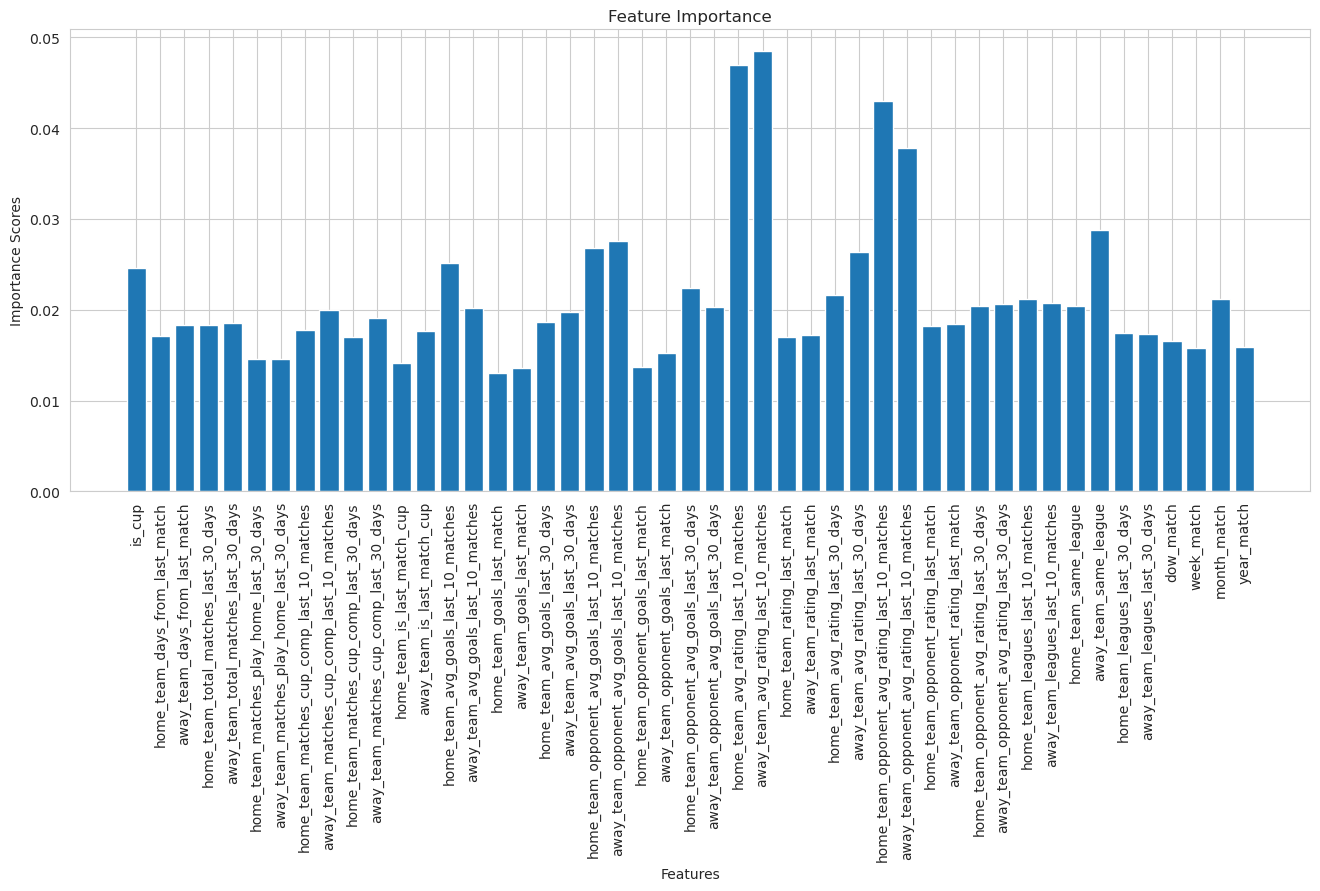

In [ ]:
plt.figure(figsize=(16, 6))
plt.bar(range(len(importance_scores)), importance_scores)
plt.xticks(range(len(importance_scores)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importance')
plt.show()

In [ ]:
score = importance_scores.tolist()

In [ ]:
col_names = X.columns.tolist()

In [ ]:
df_importance = pd.DataFrame({'feature':col_names,
                              'score':score})

In [ ]:
df_importance.describe()

- Try to remove features with importance lower than the median

In [ ]:
selected_features_df = df_importance[df_importance['score']<0.01863]

In [ ]:
selected_features = selected_features_df['feature'].values.tolist()
len(selected_features)

In [ ]:
len(col_names)

In [ ]:
print(f"Remove {len(selected_features)} out of {len(col_names)} features")

- Train model again

In [ ]:
model_2 = xgb.XGBClassifier()

In [ ]:
model_2.fit(X_train, y_train)

In [ ]:
y_pred_2 = model_2.predict(X_test)

In [ ]:
accuracy_2 = accuracy_score(y_test, y_pred_2)
print("Accuracy after dropping less important features: ", accuracy_2)

In [ ]:
print('Accuracy before dropping less important features: ',accuracy)

- Inititial, the model with features for the last 30 days had the accuracy ~ 46%, and after adding features for the last whole 10 matches, the accuracy has increased to ~ 49%
- And after removing the features which have less impact to the model (score<median score), there is nothing change to the model, therefore, if the data amount increases, can consider to drop features to optimize the training speed

In [ ]:
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

In [ ]:
def objective(eta, gamma, subsample, max_depth, min_child_weight):
    params = {
        'eta': eta,
        'gamma': gamma,
        'subsample': subsample,
        'max_depth': int(max_depth),
        'min_child_weight': int(min_child_weight),
        'eval_metric': 'error'
    }
    clf = xgb.XGBClassifier(**params)
    dtrain = xgb.DMatrix(X_train_reduced, label=y_train)
    cv_results = xgb.cv(params, dtrain, nfold=5)
    return -cv_results['test-error-mean'].max()

optimizer = BayesianOptimization(
    f=objective,
    pbounds={
        'subsample': (0.1, 0.5),
        'eta': (0.01, 0.1),
        'gamma': (0, 1),
        'max_depth': (3, 10),
        'min_child_weight': (1, 5),
    },
    verbose=1,
)

optimizer.maximize()

best_params = optimizer.max['params']

# Convert float to integer, because the optimizer will generate float, and it will trigger error
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

In [ ]:
best_params

In [ ]:
model_3 = xgb.XGBClassifier(**best_params)
model_3.fit(X_train_reduced, y_train)

In [ ]:
y_pred_3 = model_3.predict(X_test_reduced)

In [ ]:
accuracy_3 = accuracy_score(y_test, y_pred_3)
accuracy_3

# Save the models

Since there is no improvement, the original model shall be used

In [ ]:
model_path = "../../models/demo_model.model"

model.save_model(model_path)

# Check if the model file was saved
if os.path.exists(model_path):
    print("Model saved successfully.")
else:
    print("Failed to save the model.")

# Conclusion

- There is no improvement by fine tunning the model, this mostly indicates that the issue is at the dataset, not the model.
- But due to the time limitation, I will just stop right here, and provide few plans moving forward to increase the accuracy:
    + Analyze the dataset deeper and extract the more meaningful features
    + Apply feature importance again to just select the most important features, focus on these, inspect the data quality, extract more insights if possible from these features
    + Collect external data sources if possible (weather, people-related data such as team members info, etc)